In [13]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'titanic:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-competitions-data%2Fkaggle-v2%2F3136%2F26502%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240610%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240610T115259Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D742df61332faa4ffc24fe825ab950370424546db73a8fe6c985df184073ea01ded03226c2103bbaec9ef0ac8e479140a17747fa774c90c3cd6337bf950fa291c4905a961030a5c2d9abbf0bc69c87c2edd3e7242f7bdd57c088a8ce99e00cc322cc472574824f2d4cbd4d05b20821ff3963eccc7c0cc219813da006d101653eac65e495cf38838edbe2d13e1b24b36415dc7b17c5d8a28b04edf213cacd8f19467c2e5ef6327cd5174f5952d9283197f5a4c2c41ca16982cdc44bad910d4dcb33183906500a7dc20a8e0f8fb091c504dbea9c5777cdf56c7078dc8f35df1693fb61d4b4516212f01b813cab6d8abfcf509984cb1125711e18b7cb8d7d2973fd5'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')



[==================================================] 34877 bytes downloaded

Downloaded and uncompressed: titanic

Data source import complete.


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv

/kaggle/input/titanic/gender_submission.csv

/kaggle/input/titanic/test.csv


1. Read the data.
2. Descriptive and statistical analysis.
3. Understand data
4. EDA
5. Data cleaning
6. Feature Engineering
7. ML modelling
8. Evaluation
9. Submission

In [10]:
# Read the data
path = '/kaggle/input/titanic/train.csv'

titanic_df = pd.read_csv(path)
titanic_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [11]:
# Understand the data & fix headers
print(titanic_df.info())
print(titanic_df.describe())

<class 'pandas.core.frame.DataFrame'>

RangeIndex: 891 entries, 0 to 890

Data columns (total 12 columns):

 #   Column       Non-Null Count  Dtype  

---  ------       --------------  -----  

 0   PassengerId  891 non-null    int64  

 1   Survived     891 non-null    int64  

 2   Pclass       891 non-null    int64  

 3   Name         891 non-null    object 

 4   Sex          891 non-null    object 

 5   Age          714 non-null    float64

 6   SibSp        891 non-null    int64  

 7   Parch        891 non-null    int64  

 8   Ticket       891 non-null    object 

 9   Fare         891 non-null    float64

 10  Cabin        204 non-null    object 

 11  Embarked     889 non-null    object 

dtypes: float64(2), int64(5), object(5)

memory usage: 83.7+ KB

None

       PassengerId    Survived      Pclass         Age       SibSp  \

count   891.000000  891.000000  891.000000  714.000000  891.000000   

mean    446.000000    0.383838    2.308642   29.699118    0.523008   

std   

In [ ]:
# Handle missing values

In [ ]:
# EDA (Exploratory Data Analysis)

In [ ]:
# Prepare for ML modelling

In [ ]:
# Apply ML models

## Using code from chatgpt

I am not able to start anywhere, so asked my best friend chatgpt to give solution. I do have some assumption so I'll build upon his/her/they/their/it's work. I know it doesn't give the right working solution but I'm atleast smart enough to make it work.

1. It didn't know the right path and got error in first cell itself.
2. It doesn't give print to check what the heck it did before.


In [ ]:
# Read data
import pandas as pd

# Load the data
path = '/kaggle/input/titanic/'
train = pd.read_csv(path+'train.csv')
test = pd.read_csv(path+'test.csv')

In [ ]:
# Data exploration and cleaning

# Explore the data
print(train.head())
print(train.info())
print(train.describe())

# Handle missing values
# Fill missing Age values with the median age
train['Age'].fillna(train['Age'].median(), inplace=True)
test['Age'].fillna(test['Age'].median(), inplace=True)

# Fill missing Embarked values with the most common port
train['Embarked'].fillna(train['Embarked'].mode()[0], inplace=True)

# Fill missing Fare values in the test set with the median fare
test['Fare'].fillna(test['Fare'].median(), inplace=True)


   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S  
<c

/tmp/ipykernel_33/2504772416.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train['Age'].fillna(train['Age'].median(), inplace=True)
/tmp/ipykernel_33/2504772416.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)'

In [ ]:
# Feature Engineering

# Convert categorical features to numerical
train['Sex'] = train['Sex'].map({'male': 0, 'female': 1})
test['Sex'] = test['Sex'].map({'male': 0, 'female': 1})

# Create dummy variables for the 'Embarked' feature
train = pd.get_dummies(train, columns=['Embarked'], drop_first=True)
test = pd.get_dummies(test, columns=['Embarked'], drop_first=True)

# Select relevant features
features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked_Q', 'Embarked_S']
X_train = train[features]
y_train = train['Survived']
X_test = test[features]


In [ ]:
# Model Training
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Split the training data for validation
X_train_split, X_valid, y_train_split, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Train the model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_split, y_train_split)

# Validate the model
y_pred = model.predict(X_valid)
accuracy = accuracy_score(y_valid, y_pred)
print(f'Validation Accuracy: {accuracy:.2f}')


Validation Accuracy: 0.80


# Titanic 02

## Read the data

In [3]:
# Read the data
path = '/kaggle/input/titanic/train.csv'

titanic_df = pd.read_csv(path)
titanic_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [12]:
titanic_df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


## Understanding the survivors data

Although the data might not be accurate, it was meant to discover the reasons behind surviours. For that we need to examine all features.

There are 12 columns, where one column is the label and other id. Leaving us with 10 columns to deal with. Let's start with some EDA.

In [4]:
# statistical data
titanic_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [5]:
titanic_df.info()

<class 'pandas.core.frame.DataFrame'>

RangeIndex: 891 entries, 0 to 890

Data columns (total 12 columns):

 #   Column       Non-Null Count  Dtype  

---  ------       --------------  -----  

 0   PassengerId  891 non-null    int64  

 1   Survived     891 non-null    int64  

 2   Pclass       891 non-null    int64  

 3   Name         891 non-null    object 

 4   Sex          891 non-null    object 

 5   Age          714 non-null    float64

 6   SibSp        891 non-null    int64  

 7   Parch        891 non-null    int64  

 8   Ticket       891 non-null    object 

 9   Fare         891 non-null    float64

 10  Cabin        204 non-null    object 

 11  Embarked     889 non-null    object 

dtypes: float64(2), int64(5), object(5)

memory usage: 83.7+ KB


### **Observation**
- There are total 891 passengers.
- There are missing values in columns Age, Cabin, Embarked.

In [6]:
# Divide the features into categories, will use later

# PassengerId has no use
numerical_columns = ['Age', 'Fare', 'SibSp', 'Parch']

# Integer categorical
encoded_categorical_columns = ['Survived', 'Pclass']

# need encoding categorical columns
categorical_columns = ['Sex', 'Embarked']

# Complex columns
complex_columns = ['Ticket', 'Cabin', 'Name']

## Data Visualization

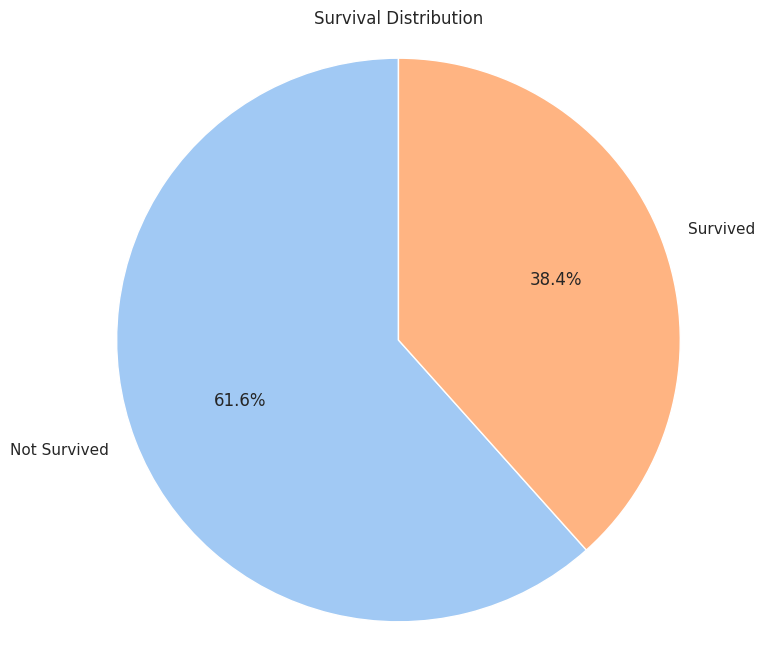

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Labels for the pie chart
labels = ['Not Survived', 'Survived']

# Set Seaborn style
sns.set(style="whitegrid")

# Labels for the pie chart
labels = ['Not Survived', 'Survived']

# Colors for the pie chart using Seaborn color palette
colors = sns.color_palette('pastel')[0:2]

# Create the pie chart
plt.figure(figsize=(8, 8))
plt.pie(titanic_df['Survived'].value_counts(), labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
plt.title('Survival Distribution')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

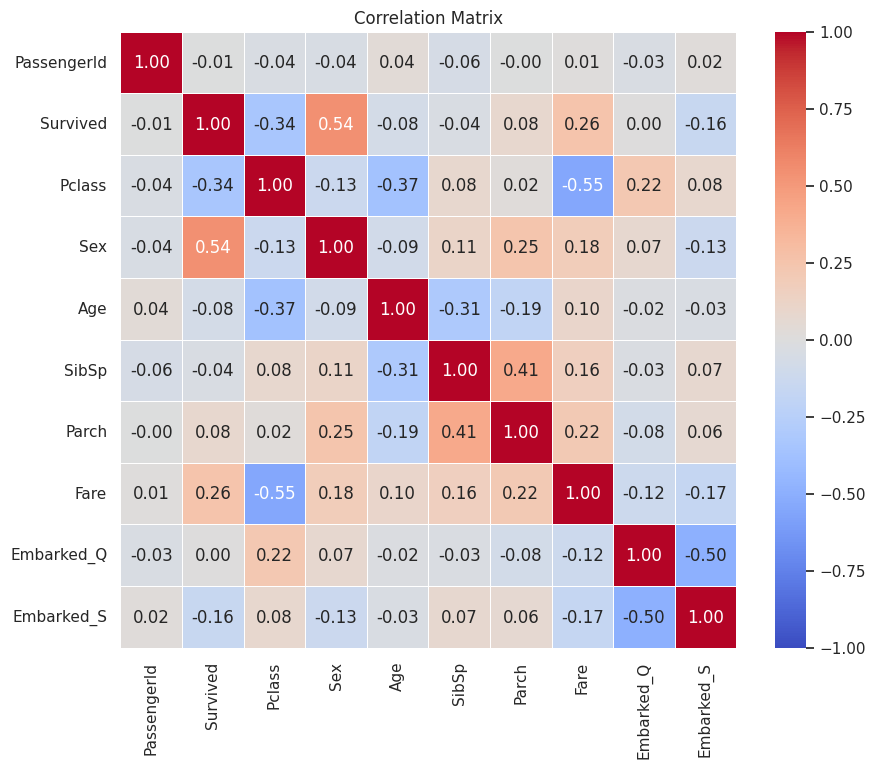

In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Encode 'Sex' using label encoding
titanic_df['Sex'] = titanic_df['Sex'].map({'male': 0, 'female': 1})

# Encode 'Embarked' using one-hot encoding
titanic_df = pd.get_dummies(titanic_df, columns=['Embarked'], drop_first=True)


# Compute the correlation matrix
correlation_matrix = titanic_df.drop(columns=['Ticket', 'Cabin', 'Name']).corr()

# Set the style of the visualization
sns.set(style="white")

# Create a mask for the upper triangle (optional, to make the plot more readable)
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm',
            vmin=-1, vmax=1, center=0, square=True, linewidths=.5)

plt.title('Correlation Matrix')
plt.show()


### Observation

- Gender of the passenger has highest corelation.
- Next is the Fare of ticket.
- And none of the other show any strong correlation.

## Handle missing values

In [24]:
# Columns with missing values
for col in titanic_df.columns:
    missing_values = titanic_df[col].isnull().sum()
    if missing_values > 0:
      print(f"Column: {col}, Missing values: {missing_values}")

Column: Age, Missing values: 177

Column: Cabin, Missing values: 687

Column: Embarked, Missing values: 2


In [25]:
# Embarked missing rows
titanic_df[titanic_df['Embarked'].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


In [21]:
# Check if someone has Ticket: 113572 or Cabin: B28
titanic_df[(titanic_df['Ticket'] == 113572) | (titanic_df['Cabin'] == 'B28')]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


In [28]:
# fill missing values with mode in titanic_df for Embarked
df_without_missing = titanic_df
df_without_missing['Embarked'].fillna(df_without_missing['Embarked'].mode()[0], inplace = True)
df_without_missing.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


<Axes: xlabel='Age', ylabel='Count'>

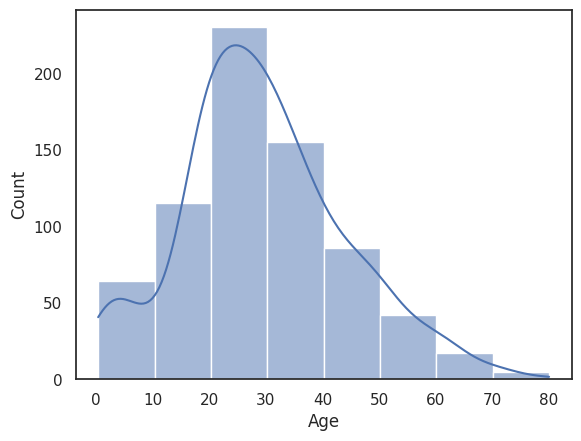

In [31]:
# let's see the distribution of Age in titanic df
sns.histplot(data=titanic_df, x='Age', kde=True, bins=8)

In [40]:
# Pclass of age missing values
missing_age_df = titanic_df[titanic_df['Age'].isnull()]
missing_age_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,177.000000,177.000000,177.000000,0.0,177.000000,177.000000,177.000000
mean,435.581921,0.293785,2.598870,NaN,0.564972,0.180791,22.158567
std,250.552901,0.456787,0.763216,NaN,1.626316,0.534145,31.874608
min,6.000000,0.000000,1.000000,NaN,0.000000,0.000000,0.000000
25%,230.000000,0.000000,3.000000,NaN,0.000000,0.000000,7.750000
50%,452.000000,0.000000,3.000000,NaN,0.000000,0.000000,8.050000
75%,634.000000,1.000000,3.000000,NaN,0.000000,0.000000,24.150000
max,889.000000,1.000000,3.000000,NaN,8.000000,2.000000,227.525000


<Axes: xlabel='Fare', ylabel='Count'>

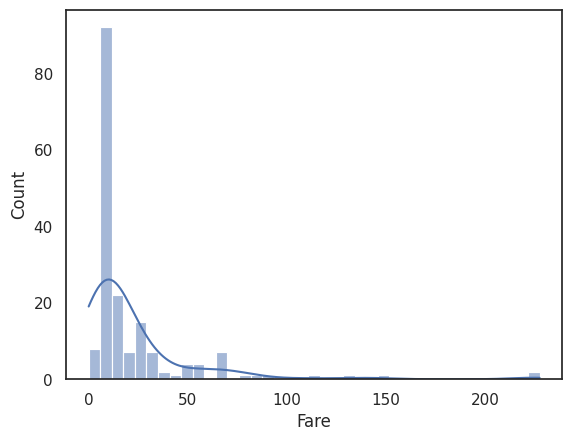

In [41]:
# plot histplots for Survived, Pclass, Fare for this missing_age_df
sns.histplot(data=missing_age_df, x='Fare', kde=True)

<Axes: xlabel='Survived', ylabel='Count'>

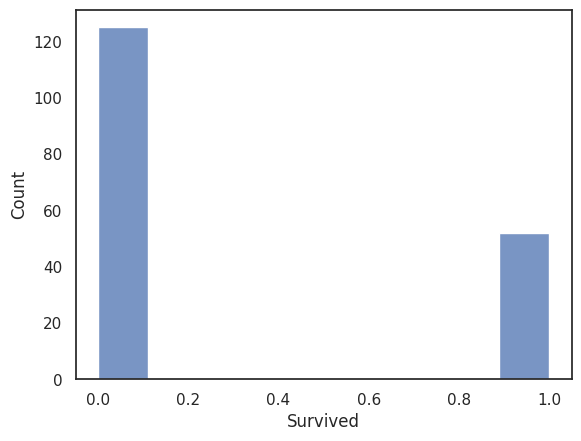

In [44]:
sns.histplot(data=missing_age_df, x='Survived')

<Axes: xlabel='Pclass', ylabel='Count'>

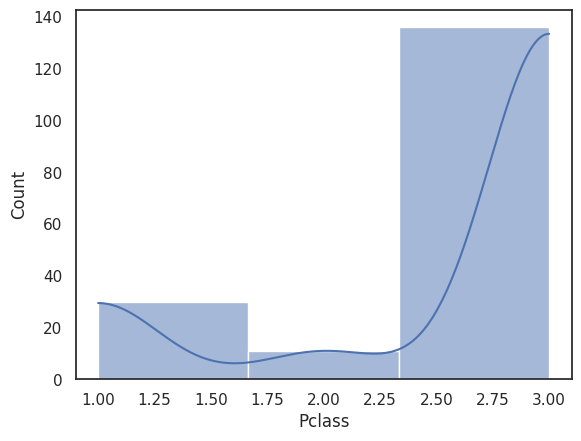

In [49]:
sns.histplot(data=missing_age_df, x='Pclass', kde=True, bins=3)

<Axes: xlabel='Sex', ylabel='Count'>

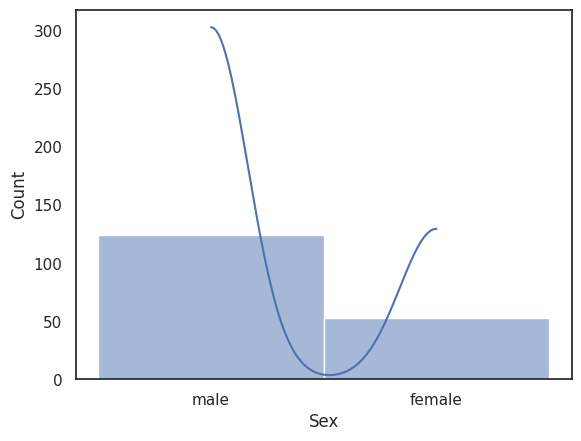

In [50]:
sns.histplot(data=missing_age_df, x='Sex', kde=True)

<Axes: xlabel='Pclass', ylabel='Count'>

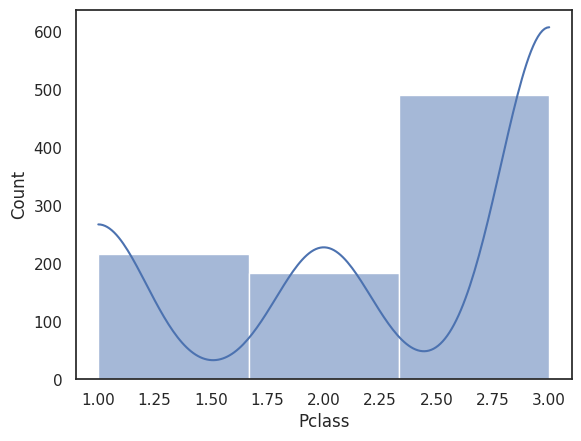

In [54]:
sns.histplot(data=titanic_df, x='Pclass', kde=True, bins=3)